## Module Imports

In [1]:
include("emulation_functions.jl")
using BenchmarkTools
using CSV
using JLD2
using Dates
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using NCDatasets
using DataFrames
using ForwardDiff
using LinearAlgebra
using NamedArrays
using Plots
using Plots.PlotMeasures
using Optimization
using OptimizationOptimJL
using Statistics
using StatsPlots
using Distributions
using Turing
#using Random
using .Threads

## Set File Directory
Set the `directory_of_files` variable below to the path leading to your folder containing all the data and emulator files.

In [3]:
# directory where all files are located. If it is this working directory, set this to "./"
directory_of_files = "../data/"; 
p_names = (:flnr,:slatop,:dleaf,:dsladlai,:leaf_long,:s_vc,:bbbopt,:mbbopt,:smpsc,:smpso,:rholvis,:rholnir,:taulvis,:taulnir,:rhosvis,:rhosnir,:xl,:displar,:z0mr,:vcmaxha,:vcmaxhd,:jmaxha,:jmaxhd,:roota_par,:rootb_par,:grperc)
p_names_dis = (:flnr,:slatop,:leaf_long, :rootb_par)

D = length(p_names_dis)

4

## Load data 

In [5]:
# Dictionaries to make this all neater
output_var_header_names = Dict{String, String}("GPP" => "GPP_NT_VUT_REF", 
                                               "NEE" => "NEE_VUT_REF", 
                                               "LH" => "LE_F_MDS", 
                                               "SH" => "H_F_MDS")
site_names = Dict{String, String}("US_Me2" => "fluxnet_US_Me2_2003_2007", 
                                  "US_Dk3" => "fluxnet_US_Dk3_2003_2007",
                                  "CA_TP4" => "fluxnet_CA_TP4_2003_2007",
                                  "US_Blo" => "fluxnet_US_Blo_2003_2007",
    );

## Load default parameters

In [7]:
p_default=[0.0509,0.01,0.04,0.0006,1.5,20.72,10000,9,-255000,-66000,0.07,0.35,0.05,0.1,0.16,0.39,0.01,0.67,0.055,72000,200000,50000,200000,3,1.25,0.3]
elements = ["flnr","slatop","dleaf","dsladlai","leaf_long","s_vc","bbbopt","mbbopt","smpsc","smpso","rholvis","rholnir","taulvis",
            "taulnir","rhosvis","rhosnir","xl","displar","z0mr","vcmaxha","vcmaxhd","jmaxha","jmaxhd","roota_par","rootb_par","grperc"]
elements_4par = ["flnr","slatop","leaf_long","rootb_par"]
p_hard = (  flnr =      [0.04, 0.3],                         
            slatop =    [0.003, 0.03],
            dleaf =     [0.03, 0.3],
            dsladlai =  [0.0002, 0.0035],
            leaf_long = [1.0, 12.0],
            s_vc =      [16.0,32.0],
            bbbopt =    [16000.0,60000.0],
            mbbopt =    [4.5, 15],
            smpsc =     [-642000.0, -125000.0],
            smpso =     [-125000.0, -17500.0],
            rholvis =   [0.025, 0.25],
            rholnir =   [0.25,0.55],
            taulvis =   [0.005,0.20],
            taulnir =   [0.15,0.45],
            rhosvis =   [0.05,0.30],
            rhosnir =   [0.20,0.75],
            xl =        [-0.5,0.375],
            displar =   [0.6,0.85],
            z0mr =      [0.04,0.09],
            vcmaxha =   [45000.0,90000.0],
            vcmaxhd =   [198000.0, 202000.0],
            jmaxha =    [30000.0,65000.0],
            jmaxhd =    [198000.0, 202000.0],
            roota_par = [2.0,18.0],
            rootb_par = [0.5,6.0],
            grperc =    [0.125,0.375] );

p_hard = [getproperty(p_hard, pn) for pn in propertynames(p_hard)];
p_hard_l = mapreduce(permutedims, vcat, p_hard)[:, 1];
p_hard_u = mapreduce(permutedims, vcat, p_hard)[:, 2];
p_norm = (p_default.- p_hard_l) ./ (p_hard_u .- p_hard_l)

26-element Vector{Float64}:
  0.041923076923076924
  0.25925925925925924
  0.03703703703703704
  0.1212121212121212
  0.045454545454545456
  0.29499999999999993
 -0.13636363636363635
  0.42857142857142855
  0.7485493230174082
  0.5488372093023256
  0.2
  0.3333333333333332
  0.23076923076923078
 -0.1666666666666666
  0.44
  0.3454545454545454
  0.5828571428571429
  0.28000000000000025
  0.3
  0.6
  0.5
  0.5714285714285714
  0.5
  0.0625
  0.13636363636363635
  0.7

## NOTE: 
You should *only* specify (as a String) `site_to_calibrate_to`, `site_of_emulator`, and `output_of_interest` variables, and the code will find the files and create variables for you automatically. This is to avoid copy-paste errors. 

`site_to_calibrate_to` is a site location that is different from `site_of_emulator`. 

`output_of_interest` is the output variable we are interested in calibrating the emulator for.

#### Options: 
#### `site_to_calibrate_to` and `site_of_emulator`
+ "US_Me2"
+ "CA_TP4"
+ Add others to the `Dict{}` above

#### `output_of_interest`
+ "GPP"
+ "NEE"
+ "LH"
+ "SH"


In [9]:
# == SPECIFY THESE PARAMETERS TO SELECT OUTPUT VAR, SITE EMULATOR, AND CALIBRATION SITE OF INTEREST ===
c_site1_to_calibrate_to = "US_Me2"
c_site2_to_calibrate_to = "US_Dk3"
c_site3_to_calibrate_to = "US_Blo"
c_site4_to_calibrate_to = "CA_TP4"
c_site5_to_calibrate_to = "US_NR1"
c_site6_to_calibrate_to = "CA_Qfo"
c_site7_to_calibrate_to = "CA_Obs"
c_site8_to_calibrate_to = "CA_TP1"
c_site9_to_calibrate_to = "CA_TP2"
c_site10_to_calibrate_to = "CA_TP3"

t_site1_to_predict_to = "CA_Qfo"
output_of_interest = "GPP"


"GPP"

## NOTE:
I am assuming a naming convention for the emulator files. I don't know what the purpose of the trailing number is, so I think all emulator filenames should be: 
`emulator_(output_of_interest)_(site_of_emulator).jld2` 

In [11]:
#site =  site_names[site_to_calibrate_to]
output = output_var_header_names[output_of_interest]
begin_date = "2003" # Begin date of fluxnet data file (in case this changes in the future)
end_date = "2007" # End data of fluxnet data file (in case this changes in the future)

"2007"

In [12]:
function calculate_10day_average(data0)
    num_years = 5 
    monthday=[10, 10,11,10,10,8,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11];
    monthly_average = Vector{Float64}()
    end_day=0
    for year in 1:num_years
        start_day=end_day+1
        for month in 1:36
            end_day = start_day + monthday[month]-1
            temp=mean(filter(!isnan,data0[start_day:end_day,:]), dims=1)
            push!(monthly_average,temp[1])
            start_day=end_day+1
        end
    end
    println(typeof(monthly_average))
    println(size(monthly_average))
    return monthly_average 
end



calculate_10day_average (generic function with 1 method)

In [13]:
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_GPP = Array(data[!, "GPP_NT_VUT_REF"])
id_1=findall(y_site1_GPP.<0)
y_site1_GPP[id_1].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_NEE = Array(data[!, "NEE_VUT_REF"])
#id_2=findall(y_site1_NEE.<0)
#y_site1_NEE[id_2].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_FSH = Array(data[!, "H_F_MDS"])
#id_3=findall(y_site1_FSH.<0)
#y_site1_FSH[id_3].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1_LH = Array(data[!, "LE_F_MDS"]);
#id_4=findall(y_site1_LH.<0)
#y_site1_LH[id_4].=0

In [14]:
GPP_01 = calculate_10day_average(y_site1_GPP)
NEE_01 = calculate_10day_average(y_site1_NEE)
FSH_01 = calculate_10day_average(y_site1_FSH)
LH_01= calculate_10day_average(y_site1_LH)


Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 12.382442999999999
  9.210005
 22.432102727272728
 11.999566999999999
 18.717375
 22.1399
 27.24223
 34.53917
 39.72402727272728
 29.98108
 40.022459999999995
 34.43771
 34.63343
  ⋮
 22.72415
 19.717852
 21.755969999999998
 30.007879999999993
 32.15707
 28.799963636363643
 30.05639
 35.535591999999994
 38.36195
 11.491902
 22.019117
 31.105345454545454

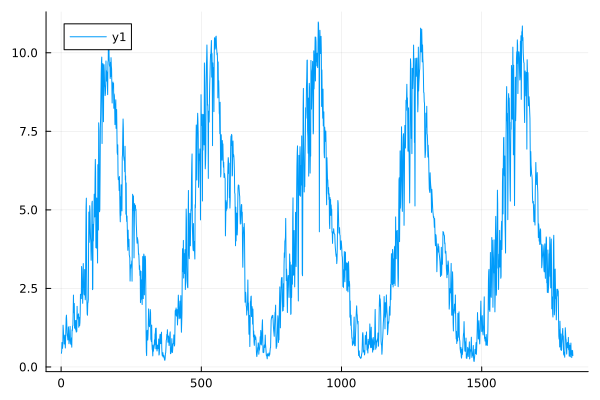

In [15]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_Me2_be_200=GPP1[:,144]
#GPP_Me2_be_200=GPP1[:,8]
plot(GPP_Me2_be_200)

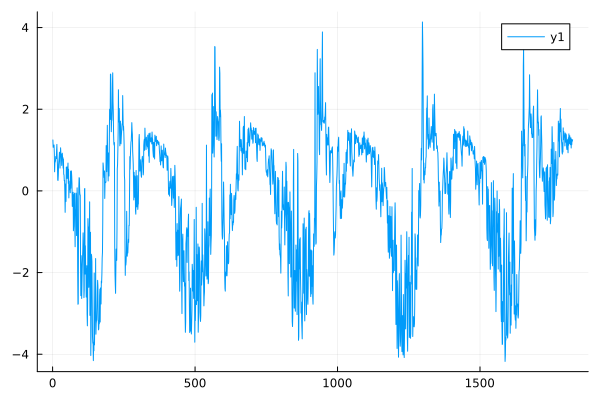

In [16]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_NEE_200_4par.txt", DataFrame; header = false, transpose=true);
NEE1 = Matrix(ensembles0)'*24*3600
ensembles_mNEE1 = mean(NEE1, dims=1)
NEE_Me2_be_200=NEE1[:,136]
plot(NEE_Me2_be_200)


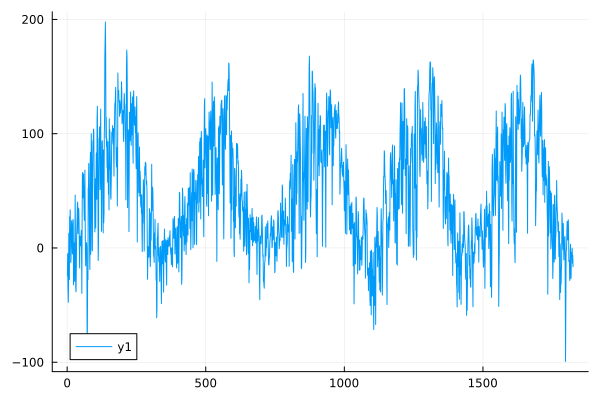

In [17]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_FSH_200_4par.txt", DataFrame; header = false, transpose=true);
FSH1 = Matrix(ensembles0)'
ensembles_mFSH1 = mean(FSH1, dims=1)
FSH_Me2_be_200=FSH1[:,148]
plot(FSH_Me2_be_200)

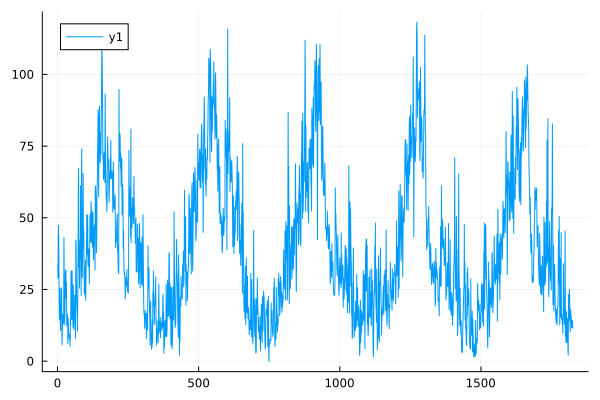

In [18]:
ensembles0 = CSV.read("../data/parameters_normalized_emulator_result_US_Me2_LH_200_4par.txt", DataFrame; header = false, transpose=true);
LH1 = Matrix(ensembles0)'
ensembles_mLH1 = mean(LH1, dims=1)
LH_Me2_be_200=LH1[:,184]
plot(LH_Me2_be_200)

In [19]:
a1=std(y_site1_GPP-GPP_Me2_be_200)
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_10day_average(GPP_Me2_be_200+iid_normal_noise1)
a2=std(y_site1_NEE-NEE_Me2_be_200)
iid_normal_noise2 = a2*randn(1825)
NEE_01_be=calculate_10day_average(NEE_Me2_be_200+iid_normal_noise2)


Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
  0.93878341847364
  0.7638550762968792
  0.5261928269364033
  0.37890597304214485
  0.2632643137750909
  0.5854292364691815
  0.36270120510403875
 -0.8806087931437849
 -1.9524847470261568
 -0.17223354879027092
 -3.026745198239656
 -2.0868705140503754
 -1.4053579972623589
  ⋮
  1.448674011701184
  0.9448703089340238
  0.5483785747393094
 -0.5045981969323398
 -0.1655134800570594
  0.6341352843607587
  0.458885912871018
  0.881190618273614
  0.6587095601591111
  0.7307470325028094
  0.356966979657969
  1.2581672781130442

In [20]:
a3=std(y_site1_FSH-FSH_Me2_be_200)
iid_normal_noise3 = a3*randn(1825)
FSH_01_be=calculate_10day_average(FSH_Me2_be_200+iid_normal_noise3)
a4=std(y_site1_LH-LH_Me2_be_200)
iid_normal_noise4 = a4*randn(1825)
LH_01_be=calculate_10day_average(LH_Me2_be_200+iid_normal_noise4)

Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 26.848383368387864
 16.152218019235477
 29.996274184904202
 18.433687083555043
  3.21607475224899
  6.117692899669237
 16.26021455600966
 37.722404311054795
 45.26465237996504
 33.670086943631446
 42.06228464013813
 50.00380062665213
 40.22900137927552
  ⋮
 30.140002625974734
 21.76401813929416
 31.445955017641676
 43.167427502901646
 47.54720383258123
 30.690640172101656
 22.986927847066667
 23.366103912923517
 20.96192464644249
 14.096824275872006
 15.103726680174905
 19.61105907961238

In [21]:
a1=std(y_site1_GPP-GPP_Me2_be_200)
a2=std(y_site1_NEE-NEE_Me2_be_200)
a3=std(y_site1_FSH-FSH_Me2_be_200)
a4=std(y_site1_LH-LH_Me2_be_200)
println([a1,a2,a3,a4])

[1.4239187436784906, 1.4834986291034913, 38.7944040955488, 17.868153217165265]


## Load emulator (all GPs used in reconstruction)

In [23]:
emulator_filename1 = "./emulator_GPP_US_Me2_200_4par.jld2";
@load emulator_filename1 array_GP pca_fit μ_z σ_z
emulator_components1 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename2 = "./emulator_NEE_US_Me2_200_4par.jld2";
@load emulator_filename2 array_GP pca_fit μ_z σ_z
emulator_components2 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename3 = "./emulator_FSH_US_Me2_200_4par.jld2";
@load emulator_filename3 array_GP pca_fit μ_z σ_z
emulator_components3 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename4 = "./emulator_LH_US_Me2_200_4par.jld2";
@load emulator_filename4 array_GP pca_fit μ_z σ_z
emulator_components4 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);

┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64

In [24]:
emulator_filename5 = "$(directory_of_files)/emulator_$(output_of_interest)_$(c_site5_to_calibrate_to)_200_4par.jld2";
@load emulator_filename5 array_GP pca_fit μ_z σ_z
emulator_components5 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);

┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241


## Bayesian Parameter Calibration

## Create probabilistic model

Our likelihood looks like linear regression and features discrepency terms $\beta_0$ and $\beta_1$ in addition to noise term $\epsilon$.

### Likelihood: 
$$y \sim \beta_1 GP(\theta) + \beta_0 + \epsilon, \qquad $$
$$\epsilon \stackrel{iid}{\sim} N(0,\sigma^2)$$

for now we assume a known $\sigma$, but we could estimate this parameter as well. $y$ is any quantity of interest predicted by the GP, $\theta$ are the model parameters (from the ELM model, the set of 26 params)

### Priors: 

$$\theta \sim p(\theta)$$ 
$$p(\theta) = Normal(0.5,0.25)$$
$$\log(\sigma) \sim N(\log 1, ((\log 2)/2)^2)$$

And I chose Normal priors for the regression parameters and LogNormal for the standard deviation. 


Define Prior distributions

ZJ: I change the priors and define the prob_model for each site, as the emulators are different

### Qoi 1

In [26]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_1(θ,N_PCA)= calibration_emulator1(θ, emulator_components1, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [27]:
@model function prob_model_1(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_1(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_1 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample=5000
N_chain = 5
model = prob_model_1(GPP_01_be, N_param, 12)
@time chain1 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain1 = replacenames(chain1, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1.jld2" chain1

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain1 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_monthly_average(GPP_Me2_be_200+iid_normal_noise1)
@time chain1[n] = Turing.sample(prob_model_1(GPP_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain1[n]  = replacenames(chain1[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_GPP_be_a1_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain1

### Qoi 2

In [30]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_2(θ,N_PCA)= calibration_emulator1(θ, emulator_components2, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [31]:
@model function prob_model_2(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_2(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_2 (generic function with 2 methods)

In [ ]:
plot(FSH_01_be)

In [ ]:

alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5
model = prob_model_2(NEE_01_be, N_param, 12)
@time chain2 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain2 = replacenames(chain2, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1.jld2" chain2

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain2 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise2 = a2*randn(1825)
NEE_01_be=calculate_monthly_average(NEE_Me2_be_200+iid_normal_noise2)
@time chain2[n] = Turing.sample(prob_model_2(NEE_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain2[n]  = replacenames(chain2[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_NEE_be_a2_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain2

### Qoi 3

In [36]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_3(θ,N_PCA)= calibration_emulator1(θ, emulator_components3, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [37]:
@model function prob_model_3(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_3(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_3 (generic function with 2 methods)

In [ ]:

alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain =5
model = prob_model_3(FSH_01_be, N_param, 12)
@time chain3 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain3 = replacenames(chain3, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1.jld2" chain3

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain3 = Array{Any}(undef, 5);

for n=1:5
iid_normal_noise3 = a3*randn(1825)
FSH_01_be=calculate_monthly_average(FSH_Me2_be_200+iid_normal_noise3)
@time chain3[n] = Turing.sample(prob_model_3(FSH_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain3[n]  = replacenames(chain3[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_FSH_be_a3_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain3

### Qoi 4

In [38]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_4(θ,N_PCA)= calibration_emulator1(θ, emulator_components4, N_PCA)/3600/24;

Q(y)=mean(y)

Q (generic function with 1 method)

In [39]:
@model function prob_model_4(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    #β_0 ~ Normal(0, 1/3)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_4(θ,N_PCA)
    
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_4 (generic function with 2 methods)

In [ ]:

alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample = 5000
N_chain = 5
model = prob_model_4(LH_01_be, N_param, 12)
@time chain4 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain4 = replacenames(chain4, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1.jld2" chain4

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 1
chain4 = Array{Any}(undef, 5);
for n=1:5
iid_normal_noise4 = a4*randn(1825)
LH_01_be=calculate_monthly_average(LH_Me2_be_200+iid_normal_noise4)
@time chain4[n] = Turing.sample(prob_model_4(LH_01_be, N_param, 12), alg, strategy, N_sample, N_chain; progress=true)
chain4[n]  = replacenames(chain4[n], Dict("p[$i]" => p_names_dis[i] for i in 1:D))
end
@save "US_Me2_LH_be_a4_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain4

In [59]:
using CairoMakie

In [60]:
N_param=4
chain_site1_prior = Turing.sample(prob_model_1(GPP_01,N_param,12), Prior(), 5000)
chain_site1_prior = replacenames(chain_site1_prior, Dict("p[$n]" => p_names_dis[n] for n in 1:D))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (5000×7×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 22.35 seconds
Compute duration  = 22.35 seconds
parameters        = flnr, slatop, leaf_long, rootb_par, β_1, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        flnr    0.4986    0.2179     0.0031    0.0030   5049.5048    0.9998    ⋯
      slatop    0.4983    0.2187     0.0031    0.0031   4776.4744    1.0005    ⋯
   leaf_long    0.4994    0.2198     0.0031    0.0030   5195.5579    1.0003    ⋯
   rootb_par    0.4993    0.2173     0.0031    0.0032   4516.4921    0.9998    ⋯
         β_1    1.0017    0.0580     0.0008    0.0009   4866.3293    0.9998    ⋯
           σ    1.0623    0.3797     0.0054    0.0046   5054.8564    1.0007    ⋯
                                                    

In [61]:
fig = Figure(size= (600, 800));

In [62]:
@load "US_Me2_GPP_be_a1_iid_nobeta0_5000_5_4par_180day_1.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_be_a2_iid_nobeta0_5000_5_4par_180day_1.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_be_a3_iid_nobeta0_5000_5_4par_180day_1.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_be_a4_iid_nobeta0_5000_5_4par_180day_1.jld2" chain4
achain4=Array(chain4)

25000×6 Matrix{Float64}:
 0.186382   0.558923  0.0679412  0.210488  0.916439  5.27275
 0.116194   0.591621  0.0781585  0.257918  0.989471  5.89742
 0.166589   0.508448  0.0622143  0.185405  0.914331  5.87872
 0.149275   0.545124  0.0781532  0.205092  0.91985   5.64039
 0.118437   0.530687  0.0998603  0.22897   0.952523  5.71877
 0.159226   0.579293  0.0530386  0.236211  0.970288  5.2242
 0.11468    0.528714  0.0736089  0.230606  0.963669  6.14335
 0.113435   0.49581   0.0922884  0.226345  0.948519  6.54493
 0.064273   0.358048  0.16       0.24743   0.927335  5.68064
 0.0672456  0.3893    0.154503   0.244841  0.929875  5.71216
 0.111976   0.4851    0.108189   0.214884  0.9226    6.05387
 0.22335    0.596477  0.0237649  0.187188  0.921332  5.21453
 0.0577455  0.409319  0.128495   0.282753  0.97714   5.82254
 ⋮                                                   ⋮
 0.174131   0.574948  0.0599029  0.201714  0.938499  5.58849
 0.153543   0.584969  0.0652728  0.214764  0.946318  5.57315
 0.151

In [63]:
ax1=Axis(fig[1, 1],ylabel="flnr",title="BE+same noise")

p1=CairoMakie.density!(ax1, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
p2=CairoMakie.density!(ax1, vec(chain1[:flnr][:,1]), color = (:red, 0.0), strokecolor = :blue, strokewidth = 3)
p3=CairoMakie.density!(ax1, vec(chain2[:flnr][:,1]), color = (:red, 0.0),  strokecolor = :red, strokewidth = 3)
p4=CairoMakie.density!(ax1, vec(chain3[:flnr][:,1]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
p5=CairoMakie.density!(ax1, vec(chain4[:flnr][:,1]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)

for i=2:4
CairoMakie.density!(ax1, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax1, vec(chain1[:flnr][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax1, vec(chain2[:flnr][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax1, vec(chain3[:flnr][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
CairoMakie.density!(ax1, vec(chain4[:flnr][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end
vlines!(ax1, [0.07], color=:blue, linewidth=1.5, label="")
vlines!(ax1, [0.13], color=:red, linewidth=1.5, label="")
vlines!(ax1, [0.35], color=:green, linewidth=1.5, label="")
vlines!(ax1, [0.21], color=:purple, linewidth=1.5, label="")
CairoMakie.xlims!(ax1,-0.0,1.0)
CairoMakie.ylims!(ax1,-2,20)
axislegend(ax1,[p1,p2,p3,p4,p5],["Prior","GPP","NEE","H","LE"], position = :rt)

Legend()

In [64]:
ax2=Axis(fig[2, 1],ylabel="slatop")

for i=1:4
CairoMakie.density!(ax2, vec(chain_site1_prior[:slatop]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain1[:slatop][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain2[:slatop][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain4[:slatop][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
CairoMakie.density!(ax2, vec(chain3[:slatop][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)

# Add vertical lines
vlines!(ax2, [0.56], color=:blue, linewidth=1.5, label="")
vlines!(ax2, [0.87], color=:red, linewidth=1.5, label="")
vlines!(ax2, [0.78], color=:green, linewidth=1.5, label="")
vlines!(ax2, [0.89], color=:purple, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax2,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)


In [65]:
ax3=Axis(fig[3, 1],ylabel="leaf_long")

for i=1:4
CairoMakie.density!(ax3, vec(chain_site1_prior[:leaf_long]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain1[:leaf_long][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain2[:leaf_long][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain4[:leaf_long][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
CairoMakie.density!(ax3, vec(chain3[:leaf_long][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)

# Add vertical lines
vlines!(ax3, [0.24], color=:blue, linewidth=1.5, label="")
vlines!(ax3, [0.8], color=:red, linewidth=1.5, label="")
vlines!(ax3, [0.08], color=:green, linewidth=1.5, label="")
vlines!(ax3, [0.01], color=:purple, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax3,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)


In [66]:
ax4=Axis(fig[4, 1],ylabel="rootb_par")

for i=1:4
CairoMakie.density!(ax4, vec(chain_site1_prior[:rootb_par]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain1[:rootb_par][:,i]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain2[:rootb_par][:,i]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain4[:rootb_par][:,i]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
CairoMakie.density!(ax4, vec(chain3[:rootb_par][:,i]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)

# Add vertical lines
vlines!(ax4, [0.11], color=:blue, linewidth=1.5, label="")
vlines!(ax4, [0.42], color=:red, linewidth=1.5, label="")
vlines!(ax4, [0.14], color=:green, linewidth=1.5, label="")
vlines!(ax4, [0.31], color=:purple, linewidth=1.5, label="")
end
CairoMakie.xlims!(ax4,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)

In [67]:
@load "US_Me2_GPP_be_a1_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain1
achain1=Array(chain1)
@load "US_Me2_NEE_be_a2_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain2
achain2=Array(chain2)
@load "US_Me2_FSH_be_a3_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain3
achain3=Array(chain3)
@load "US_Me2_LH_be_a4_diff_iid_nobeta0_5000_5_4par_180day_4var_1.jld2" chain4
achain4=Array(chain4)

5-element Vector{Any}:
 MCMC chain (5000×18×1 Array{Float64, 3})
 MCMC chain (5000×18×1 Array{Float64, 3})
 MCMC chain (5000×18×1 Array{Float64, 3})
 MCMC chain (5000×18×1 Array{Float64, 3})
 MCMC chain (5000×18×1 Array{Float64, 3})

In [68]:
ax6=Axis(fig[1, 2],title="BE+different noises")

for i=1:3
CairoMakie.density!(ax6, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain1[i][:flnr]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain2[i][:flnr]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain3[i][:flnr]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
vlines!(ax6, [0.07], color=:blue, linewidth=1.5, label="")
vlines!(ax6, [0.13], color=:red, linewidth=1.5, label="")
vlines!(ax6, [0.35], color=:green, linewidth=1.5, label="")
vlines!(ax6, [0.21], color=:purple, linewidth=1.5, label="")
# Add vertical lines
end
for i=5:5
CairoMakie.density!(ax6, vec(chain_site1_prior[:flnr]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain1[i][:flnr]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain2[i][:flnr]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax6, vec(chain3[i][:flnr]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
# Add vertical lines
end
for i=1:4
CairoMakie.density!(ax6, vec(chain4[i][:flnr]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end
CairoMakie.xlims!(ax1,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)


In [69]:
ax7=Axis(fig[2, 2],ylabel="slatop")

for i=1:3
CairoMakie.density!(ax7, vec(chain_site1_prior[:slatop]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain1[i][:slatop]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain2[i][:slatop]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain3[i][:slatop]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
vlines!(ax7, [0.56], color=:blue, linewidth=1.5, label="")
vlines!(ax7, [0.87], color=:red, linewidth=1.5, label="")
vlines!(ax7, [0.78], color=:green, linewidth=1.5, label="")
vlines!(ax7, [0.89], color=:purple, linewidth=1.5, label="")
# Add vertical lines
end
for i=5:5
CairoMakie.density!(ax7, vec(chain_site1_prior[:slatop]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain1[i][:slatop]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain2[i][:slatop]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax7, vec(chain3[i][:slatop]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
# Add vertical lines
end
for i=1:4
CairoMakie.density!(ax7, vec(chain4[i][:slatop]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
# Add vertical lines
end

CairoMakie.xlims!(ax7,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)


In [70]:
ax8=Axis(fig[3, 2],ylabel="leaf_long")

for i=1:3
CairoMakie.density!(ax8, vec(chain_site1_prior[:leaf_long]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain1[i][:leaf_long]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain2[i][:leaf_long]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain3[i][:leaf_long]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
vlines!(ax8, [0.24], color=:blue, linewidth=1.5, label="")
vlines!(ax8, [0.8], color=:red, linewidth=1.5, label="")
vlines!(ax8, [0.08], color=:green, linewidth=1.5, label="")
vlines!(ax8, [0.01], color=:purple, linewidth=1.5, label="")
# Add vertical lines
end
for i=5:5
CairoMakie.density!(ax8, vec(chain_site1_prior[:leaf_long]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain1[i][:leaf_long]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain2[i][:leaf_long]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax8, vec(chain3[i][:leaf_long]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
# Add vertical lines
end
for i=1:4
CairoMakie.density!(ax8, vec(chain4[i][:leaf_long]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
end
CairoMakie.xlims!(ax8,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)

In [71]:
ax9=Axis(fig[4, 2],ylabel="rootb_par")

for i=1:3
CairoMakie.density!(ax9, vec(chain_site1_prior[:rootb_par]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain1[i][:rootb_par]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain2[i][:rootb_par]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax9, vec(chain3[i][:rootb_par]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
vlines!(ax9, [0.11], color=:blue, linewidth=1.5, label="")
vlines!(ax9, [0.42], color=:red, linewidth=1.5, label="")
vlines!(ax9, [0.14], color=:green, linewidth=1.5, label="")
vlines!(ax9, [0.31], color=:purple, linewidth=1.5, label="")
# Add vertical lines
end
for i=5:5
CairoMakie.density!(ax9,  vec(chain_site1_prior[:rootb_par]), color = (:blue, 0.0), strokecolor = :black, strokewidth = 3)
CairoMakie.density!(ax9,  vec(chain1[i][:rootb_par]), color = (:blue, 0.0), strokecolor = :blue, strokewidth = 3)
CairoMakie.density!(ax9,  vec(chain2[i][:rootb_par]), color = (:red, 0.0), strokecolor = :red, strokewidth = 3)
CairoMakie.density!(ax9,  vec(chain3[i][:rootb_par]), color = (:green, 0.0), strokecolor = :green, strokewidth = 3)
# Add vertical lines
end
for i=1:4
CairoMakie.density!(ax9, vec(chain4[i][:rootb_par]), color = (:purple, 0.0), strokecolor = :purple, strokewidth = 3)
end

CairoMakie.xlims!(ax9,-0.0,1.0)
#CairoMakie.ylims!(ax1,-2,20)

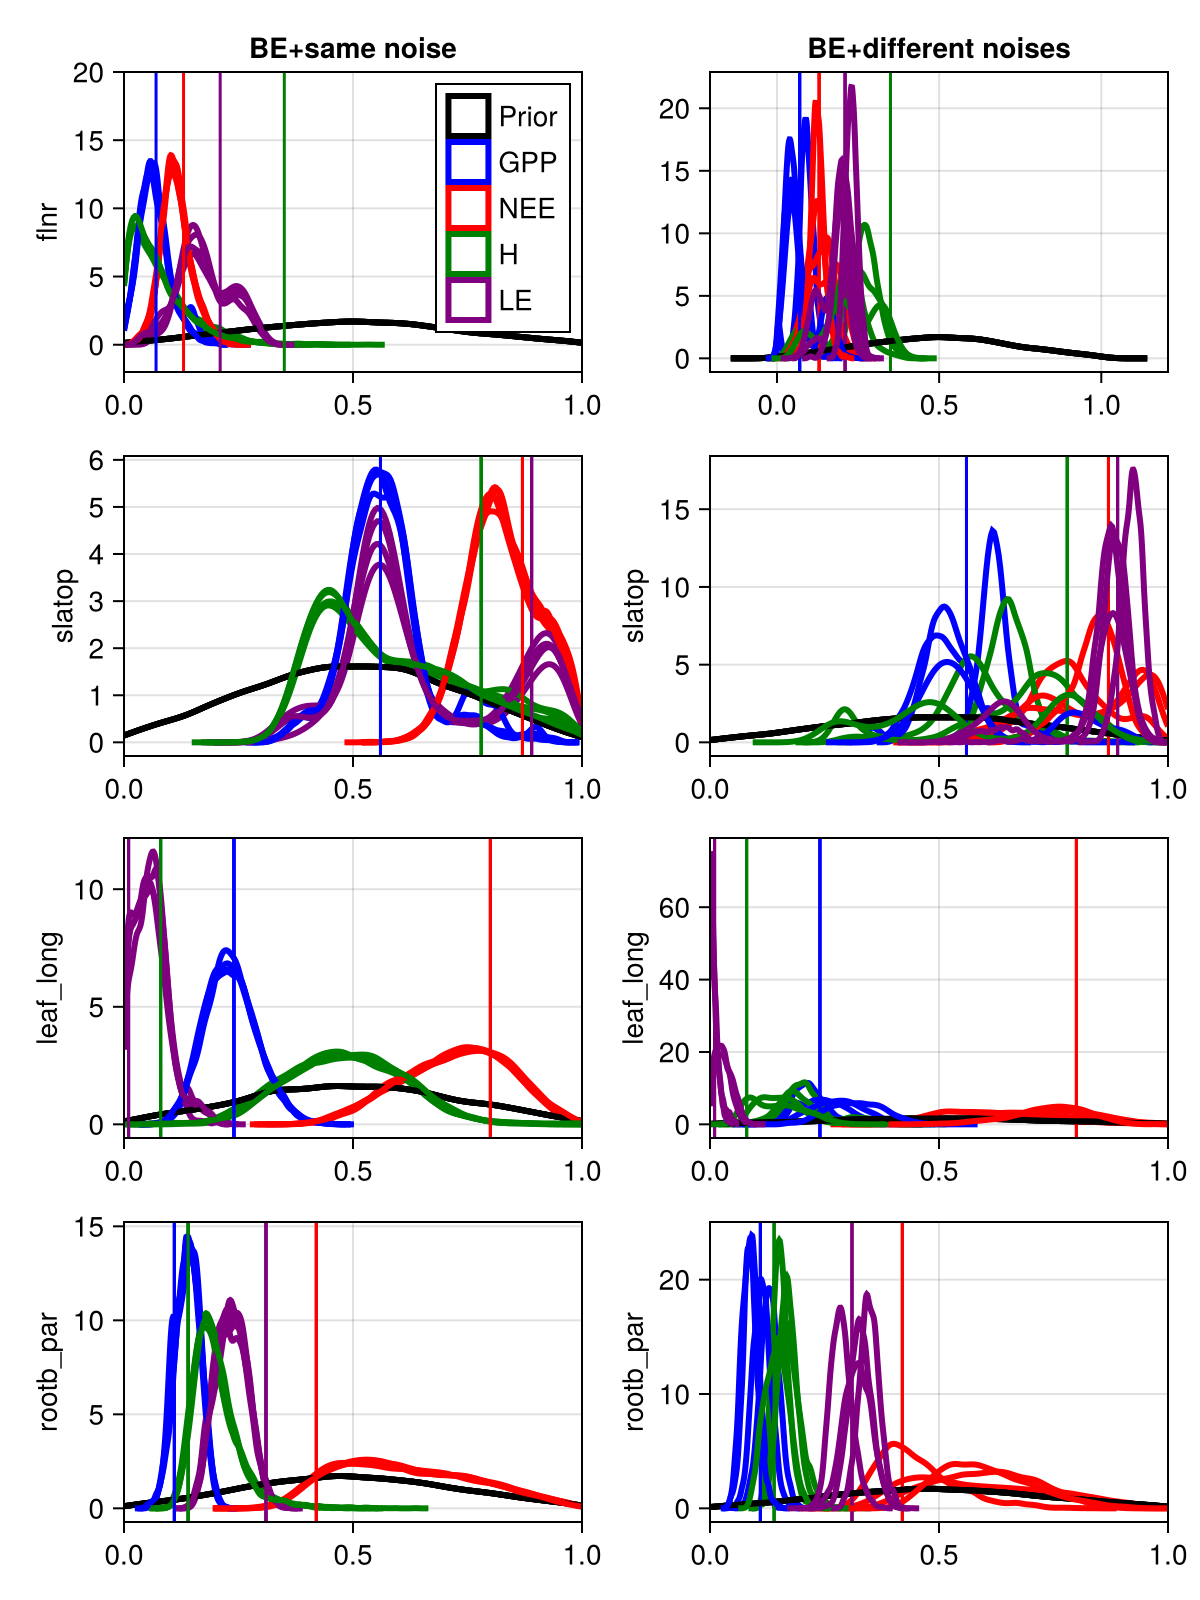

In [72]:
fig

In [73]:
save("figS1_GLMakie_4var_be_a_diff_iid_nobeta0_param_PDF_4chains_20250928.pdf",fig)

CairoMakie.Screen{PDF}
